In [1]:
%matplotlib notebook

# %qtconsole

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes as qc
from qcodes.dataset.experiment_container import new_experiment

In [2]:
from pytopo.qctools import instruments as instools
from pytopo.qctools.instruments import create_inst, add2station

# from pytopo.sweep.base import Nest, Chain
# from pytopo.sweep.decorators import getter, setter
# from pytopo.sweep import sweep, do_experiment, hardsweep, measure

In [4]:
import time
from qcodes import Measurement
from pytopo.qctools.dataset2 import select_experiment

# Define measurement functions

In [18]:
def setup_frq_sweep(fstart, fstop, fpts, chan='S21', bw=None, navgs=None, pwr=None):
    """
    Setup a VNA trace.
    
    assumes that a channel with name chan is already created.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(fstart, fstop, fpts)
    trace.start(fstart)
    trace.stop(fstop)
    trace.npts(fpts)
    if navgs is not None:
        trace.avg(navgs)
    if bw is not None:
        trace.bandwidth(bw)
    if pwr is not None:
        trace.power(pwr)
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()
    
    return fvals

def take_trace(chan='S21', plot=False, dB=True):
    """
    Get the data of a currently measured trace.
    The trace has to be setup already.
    
    Returns magnitude (in dB) and phase (in rad).
    
    If plot is true, make a simple plot of the magnitude vs frequency.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
    mag, phase = trace.trace_mag_phase()
    
    if dB:
        mag = 20*np.log10(mag)
    
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(fvals*1e-9, mag)
        ax.grid(dashes=[1,1])
        ax.set_xlabel('Frequency (GHz)')
        
        ylbl = 'Magnitude'
        if dB:
            ylbl += ' (dB)'
        ax.set_ylabel(ylbl)
        
    return mag, phase

# Init station

## Global variables

In [6]:
#SAMPLE = "DW_ResTest_002b"
SAMPLE = 'magnet_test'
qc.config.core.db_location = r'D:\OneDrive\BF1\Data\experiments_20190415.db'
qc.initialise_database()

Upgrading database: : 0it [00:00, ?it/s]


In [7]:
qc.config.core

{'default_fmt': 'data/{date}/#{counter}_{name}_{time}',
 'register_magic': True,
 'db_location': 'D:\\OneDrive\\BF1\\Data\\experiments_20190415.db',
 'db_debug': False,
 'loglevel': 'DEBUG',
 'file_loglevel': 'INFO'}

## Init instruments

In [8]:
station = qc.Station()

In [9]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
ls = instools.create_inst(Model_372, 'lakeshore_372', 'TCPIP::169.254.216.87::7777::SOCKET', 
                          force_new_instance=True)
station = add2station(station, ls)

Connected to: LSCI 372 (serial:LSA17VE, firmware:1.3) in 0.47s


In [10]:
from qcodes.instrument_drivers.rohde_schwarz.ZNB import ZNB
vna = create_inst(ZNB, 'vna', address='TCPIP::169.254.82.128::inst0::INSTR', force_new_instance=True)
#station = qc.Station(vna)
station = add2station(station, vna)
# the VNA driver has some weird default settings. 
# Make sure here that we measure what we want
vna.clear_channels()
vna.add_channel('S21')
vna.rf_off()

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101879, firmware:2.86) in 0.20s


# Testing

In [11]:
vna.timeout(100)

## Quick manual trace (without saving)

<IPython.core.display.Javascript object>


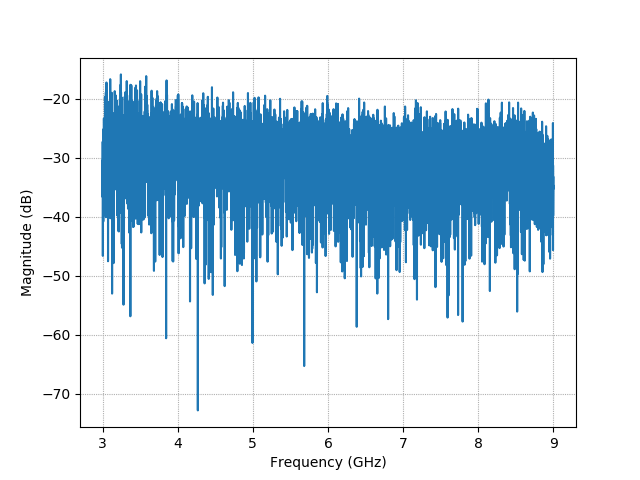

In [19]:
setup_frq_sweep(fstart=3e9, fstop=9e9, fpts=6001, pwr=-50, navgs=10, bw=10e3)
mag, phase = take_trace(plot=True)

## A single trace (with saving)

In [107]:
exp = select_experiment('VNA', SAMPLE)
meas = Measurement(exp, station)

meas.register_custom_parameter('frequency', unit='Hz',
                               paramtype='array')
meas.register_custom_parameter('magnitude', unit='dB', 
                               setpoints=['frequency'],
                               paramtype='array')
meas.register_custom_parameter('phase', unit='rad', 
                               setpoints=['frequency'],
                               paramtype='array')

with meas.run() as datasaver:
    fvals = setup_frq_sweep(fstart=3e9, fstop=8e9, fpts=5001, pwr=-40)
    mag, phase = take_trace(chan='S21', plot=False)
    result = [
        ('frequency', fvals),
        ('magnitude', mag),
        ('phase', phase)
    ]
    datasaver.add_result(*result)

Starting experimental run with id: 23


# Traces as function of time with temperature log

In [21]:
t0 = time.time()
Tm = 60 * 60 * 5

temperature = ls.ch06.temperature
temperature_sample = ls.ch09.temperature

exp = select_experiment('VNA', SAMPLE)
meas = Measurement(exp, station)
meas.register_custom_parameter('time', unit='s')
meas.register_parameter(temperature, setpoints=['time',])
meas.register_parameter(temperature_sample, setpoints=['time',])
meas.register_custom_parameter('frequency', unit='Hz',
                               paramtype='array')
meas.register_custom_parameter('magnitude', unit='dB', 
                               setpoints=['time', 'frequency'],
                               paramtype='array')
meas.register_custom_parameter('phase', unit='rad', 
                               setpoints=['time', 'frequency'],
                               paramtype='array')
with meas.run() as datasaver:
    while (time.time() - t0) < Tm:
        time.sleep(60 * 5)
        fvals = setup_frq_sweep(fstart=3e9, fstop=9e9, fpts=6001, navgs=10)
        mag, phase = take_trace(chan='S21', plot=False)

        result = [
            ('time', time.time() - t0),
            (temperature, temperature()),
            (temperature_sample, temperature_sample()),
            ('frequency', fvals),
            ('magnitude', mag),
            ('phase', phase)
        ]
        datasaver.add_result(*result)

Starting experimental run with id: 4


# Power dependence

In [ ]:
power = qc.Parameter('power', unit='dBm', set_cmd=None)

In [ ]:
power(-40)

In [ ]:
power()

In [ ]:
station.vna.rf_power()

In [ ]:
thing = station.vna.channels[0]

In [ ]:
thing

In [ ]:
thing.power.vals

In [ ]:
station.vna.visa_handle.close()
station.vna.visa_handle.open()

In [ ]:
station.vna.timeout(60)

In [ ]:
exp = select_experiment('VNA', SAMPLE)
meas = Measurement(exp, station)

meas.register_custom_parameter('power', unit='Hz')
meas.register_custom_parameter('frequency', unit='Hz',
                               paramtype='array')
meas.register_custom_parameter('magnitude', unit='dB', 
                               setpoints=[power, 'frequency'],
                               paramtype='array')
meas.register_custom_parameter('phase', unit='rad', 
                               setpoints=[power, 'frequency'],
                               paramtype='array')
with meas.run() as datasaver:
    for p in np.arange(-40, -41, -1).astype(float):
        fvals = setup_frq_sweep(fstart=3e9, fstop=9e9, fpts=40001, pwr=p)
        mag, phase = take_trace(chan='S21', plot=False)
        result = [
            ('power', p),
            ('frequency', fvals),
            ('magnitude', mag),
            ('phase', phase)
        ]
        datasaver.add_result(*result)

In [ ]:
exp = select_experiment('VNA', SAMPLE)
meas = Measurement(exp, station)

meas.register_custom_parameter('power', unit='Hz')
meas.register_custom_parameter('frequency', unit='Hz',
                               paramtype='array')
meas.register_custom_parameter('magnitude', unit='dB', 
                               setpoints=[power, 'frequency'],
                               paramtype='array')
meas.register_custom_parameter('phase', unit='rad', 
                               setpoints=[power, 'frequency'],
                               paramtype='array')
with meas.run() as datasaver:
    for p in np.arange(-40, -61, -5).astype(float):
        fvals = setup_frq_sweep(fstart=4.5e9, fstop=5.6e9, fpts=40001, pwr=p)
        mag, phase = take_trace(chan='S21', plot=False)
        result = [
            ('power', p),
            ('frequency', fvals),
            ('magnitude', mag),
            ('phase', phase)
        ]
        datasaver.add_result(*result)

# Field

let's initialize connection to the magnet

## Connection and safety checks

In [23]:
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430,AMI430_3D
def check_magnet(magnet, coil_constant, ramp_rate, current_limit, ramp_limit_multiplier=1):
    """
    magnet: ami driver
    coil_constant: T/A
    ramp_rate: A/s
    current_limit: A
    """
    assert(magnet.field_units() == 'tesla')
    assert(magnet.ramp_rate_units() == 'seconds')
    
    assert(magnet.coil_constant.unit == 'T/A')
    assert(magnet.coil_constant() == coil_constant)
    
    assert(magnet.current_ramp_limit.unit == 'A/s')
    assert(magnet.current_ramp_limit() == ramp_rate*ramp_limit_multiplier)
    
    # check the actual ramp rate!
    assert(magnet.ramp_rate.unit == 'T/s')
    assert(np.isclose(magnet.ramp_rate(), ramp_rate*magnet.coil_constant()*ramp_limit_multiplier))
    
    assert(magnet.current_limit.unit == 'A')
    assert(magnet.current_limit() == current_limit)

In [24]:
ami_y = ami_green = create_inst(AMI430, "AMI430_y", "169.254.179.21", 
                                port = 7180, has_current_rating=True, force_new_instance=True)
ami_x = ami_blue = create_inst(AMI430, "AMI430_x", "169.254.135.186", 
                               port = 7180, has_current_rating=True, force_new_instance=True)
ami_z = ami_yellow = create_inst(AMI430, "AMI430_z", "169.254.114.235", 
                                 port = 7180, has_current_rating=True, force_new_instance=True)

Connected to: AMERICAN MAGNETICS INC. 430 (serial:170026, firmware:2.57) in 1.15s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170025, firmware:2.57) in 1.08s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170024, firmware:2.57) in 1.20s


In [70]:
ami_x.field_limit(), ami_y.field_limit(), ami_z.field_limit()

(1.0000136999999998, 0.9999389999999999, 5.999796)

In [ ]:
ramp_limit_multiplier = 0.4
ami_x.current_ramp_limit(0.1742*ramp_limit_multiplier)
ami_y.current_ramp_limit(0.1762*ramp_limit_multiplier)
ami_z.current_ramp_limit(0.0756*ramp_limit_multiplier)

In [27]:
# check_magnet(ami_x, 0.01491, 0.1742, 67.07, ramp_limit_multiplier=0.4)
# check_magnet(ami_y, 0.01490, 0.1762, 67.11, ramp_limit_multiplier=0.4)
# check_magnet(ami_z, 0.0834, 0.0756, 71.94, ramp_limit_multiplier=0.4)

In [ ]:
#raise Exception()
# you should not need this code!
ramp_limit_multiplier = 0.4
ami_x.current_ramp_limit(0.1742*ramp_limit_multiplier)
ami_x.ramp_rate(0.1742*ramp_limit_multiplier*0.01491)
ami_x.coil_constant(0.01491)
ami_x.current_limit(67.07)

ami_y.current_ramp_limit(0.1762*ramp_limit_multiplier)
ami_y.ramp_rate(0.1762*ramp_limit_multiplier*0.01490)
ami_y.coil_constant(0.01490)
ami_y.current_limit(67.11)

ami_z.current_ramp_limit(0.0756*ramp_limit_multiplier)
ami_z.ramp_rate(0.0756*ramp_limit_multiplier*0.0834)
ami_z.coil_constant(0.0834)
ami_z.current_limit(71.94)

In [28]:
ami = create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)
station = add2station(station, ami)

## Magnetic field sweeps

In [29]:
SAMPLE

'magnet_test'

In [102]:
station.AMI430.phi(), station.AMI430.theta(), station.AMI430.field()

(-180.0, 0.09095697356824939, 0)

In [85]:
station.AMI430.cartesian_measured()

[-0.0007151, -0.0101826, 1.9499476]

In [101]:
temperature(), temperature_sample()

(0.0103431, 0.0169565)

In [100]:
# station.AMI430.theta(-0.3)
# station.AMI430.phi(266)
station.AMI430.field(0)

In [83]:
station.AMI430.phi(), station.AMI430.theta(), station.AMI430.field()

(85.99999999999999, -0.3, 1.95)

In [80]:
exp = select_experiment('VNA_FIELD', SAMPLE)
meas = Measurement(exp, station)


# field_vec, field_vec_unit, field_vec_name = station.AMI430.phi, 'deg', 'phi'
# field_vals = np.linspace(0, 360, 91).astype(float)

field_vec, field_vec_unit, field_vec_name = station.AMI430.theta, 'deg', 'theta'
field_vals = np.linspace(1.5 - 2, 1.5 + 2, 21).astype(float)

# field_vec, field_vec_unit, field_vec_name = station.AMI430.z, 'T', 'z'
# field_vals = np.linspace(1., 2., 51).astype(float)


temperature = ls.ch06.temperature
temperature_sample = ls.ch09.temperature


meas.register_custom_parameter(field_vec_name, unit=field_vec_unit)
meas.register_parameter(temperature, setpoints=[field_vec_name,])
meas.register_parameter(temperature_sample, setpoints=[field_vec_name,])
meas.register_custom_parameter('frequency', unit='Hz',
                               paramtype='array')
meas.register_custom_parameter('magnitude', unit='dB', 
                               setpoints=[field_vec_name, 'frequency'],
                               paramtype='array')
meas.register_custom_parameter('phase', unit='rad', 
                               setpoints=[field_vec_name, 'frequency'],
                               paramtype='array')
with meas.run() as datasaver:
    for Bval in field_vals:
        field_vec(Bval)
        fvals = setup_frq_sweep(fstart=3e9, fstop=8e9, fpts=5001, pwr=-40)
        mag, phase = take_trace(chan='S21', plot=False)
        result = [
            (field_vec_name, Bval),
            (temperature, temperature()),
            (temperature_sample, temperature_sample()),
            ('frequency', fvals),
            ('magnitude', mag),
            ('phase', phase)
        ]
        datasaver.add_result(*result)

Starting experimental run with id: 14


In [ ]:
exp = select_experiment('VNA_FIELD', SAMPLE)
meas = Measurement(exp, station)

meas.register_custom_parameter('phi', unit='deg')
meas.register_custom_parameter('frequency', unit='Hz',
                               paramtype='array')
meas.register_custom_parameter('magnitude', unit='dB', 
                               setpoints=['phi', 'frequency'],
                               paramtype='array')
meas.register_custom_parameter('phase', unit='rad', 
                               setpoints=['phi', 'frequency'],
                               paramtype='array')
with meas.run() as datasaver:
    for phi in np.linspace(360, 0, 121).astype(float):
        station.AMI430.phi(phi)
        fvals = setup_frq_sweep(fstart=3e9, fstop=9e9, fpts=6001, pwr=-40)
        mag, phase = take_trace(chan='S21', plot=False)
        result = [
            ('phi', phi),
            ('frequency', fvals),
            ('magnitude', mag),
            ('phase', phase)
        ]
        datasaver.add_result(*result)

In [ ]:
station.AMI430.theta()

In [ ]:
station.AMI430.cartesian()

In [ ]:
ds = qc.load_by_id(12)

In [ ]:
ds.snapshot

## Automatic field alignment

### Musings

pseudocode:

In [ ]:
for z from 0 to 1T:
    ami.field_prime(0, 0, z)
    sgd in x, y
    calculate new coordinate system
    # field_prime should now be in (0, 0, close to but higher than z)

I want a function `optimize()` that does the inner part of the for loop

I need asignature for this function to describe exactly what it's doing

criss' code is so opaque to me, that it will a lot faster to rewrite it

In [ ]:
setup_frq_sweep(fstart=5.3e9, fstop=5.6e9, fpts=51, pwr=-40)

In [ ]:
station.AMI430.cartesian()

In [ ]:
station.AMI430.cartesian_measured()

In [ ]:
fval = setup_frq_sweep(fstart=5.44e9, fstop=5.48e9, fpts=201, pwr=-40)
mag, phase = take_trace(plot=True)
amin = np.argmin(mag)
print(fval[amin])

### coding

In [104]:
fc = 6.263e9
df = 25e6

def opt_fun():
    global fc
    fval = setup_frq_sweep(fstart=fc-df, fstop=fc+df, fpts=501, pwr=-40)
    mag, phase = take_trace(plot=False)
    amin = np.argmin(mag)
    fc = fval[amin]
    return fc

In [94]:
for i in range(10):
    print(opt_fun())

6263100000.0
6263000000.0
6262900000.0
6263100000.0
6263100000.0
6263200000.0
6263100000.0
6263200000.0
6263100000.0
6263100000.0


very interesting, my optimization code could be completely independent from all other stuff, just an efficient wiggle function should do the trick

In [105]:
def wiggle_1d(max_radial, wiggle_step, min_wiggle, optimization_function, field_parameter):
    # picture a Roomba
    nsteps = 1
    val = optimization_function()
    direction = 1
    done = False
    while wiggle_step>min_wiggle:
        nsteps+=1
        pos = field_parameter()
        if pos+direction*wiggle_step > max_radial:
            raise Exception('radial optimization limit exceeded')
        field_parameter(pos+direction*wiggle_step)
        new_val = optimization_function()
        if new_val <= val:
            print(val, pos)
            val = new_val
            direction = -1*direction
            if direction == 1:
                wiggle_step=wiggle_step/2
        else:
            val = new_val
    print('nstep', nsteps)

In [109]:
exp = select_experiment('FIELD_ALIGNMENT_TEST', SAMPLE)
meas = Measurement(exp, station)

meas.register_custom_parameter('step', unit='#')
meas.register_custom_parameter('fres', unit='Hz',
                               setpoints=['step'])
meas.register_custom_parameter('Bx', unit='T',
                               setpoints=['step'])
max_radial = 4e-3
wiggle_step = 100e-6
min_wiggle = 5e-6
optimization_function = opt_fun
field_parameter = station.AMI430.x
with meas.run() as datasaver:
    nsteps = 1
    val = optimization_function()
    direction = 1
    done = False
    while wiggle_step>min_wiggle:
        nsteps+=1
        pos = field_parameter()
        new_pos = pos+direction*wiggle_step
        if new_pos > max_radial:
            raise Exception('radial optimization limit exceeded')
        field_parameter(new_pos)
        new_val = optimization_function()
        result = [
            ('step', nsteps),
            ('fres', new_val),
            ('Bx', new_pos),
        ]
        datasaver.add_result(*result)
        if new_val <= val:
            print(val, pos)
            val = new_val
            direction = -1*direction
            if direction == 1:
                wiggle_step=wiggle_step/2
        else:
            val = new_val
        

Starting experimental run with id: 25
6302300000.0 0.0023
6303800000.0 0.0022
6300700000.0 0.0021500000000000004
6303500000.0 0.0021000000000000003
6303400000.0 0.00205
6300800000.0 0.002075
6300700000.0 0.00205
6302400000.0 0.00205
6302600000.0 0.0020500000000000006
6302700000.0 0.0020500000000000006


In [98]:
exp = select_experiment('FIELD_ALIGNMENT_TEST', SAMPLE)
meas = Measurement(exp, station)

meas.register_custom_parameter('Bz', unit='T')
meas.register_custom_parameter('step', unit='#')
meas.register_custom_parameter('fres', unit='Hz',
                               setpoints=['Bz','step'])
meas.register_custom_parameter('Bx', unit='T',
                               setpoints=['Bz','step'])
max_radial = 10e-3
wiggle_step = 25e-6
min_wiggle = 5e-6
optimization_function = opt_fun
field_parameter = station.AMI430.x
with meas.run() as datasaver:
    for Bz in np.linspace(0.5, 1., 51):
        # this line can be improved by actually moving in a z-x direction determined by the optimal angle
        station.AMI430.z(Bz)
        max_radial = 10e-3
        wiggle_step = 25e-6
        min_wiggle = 5e-6
        nsteps = 1
        val = optimization_function()
        direction = 1
        done = False
        while wiggle_step>min_wiggle:
            nsteps+=1
            pos = field_parameter()
            new_pos = pos+direction*wiggle_step
            if new_pos > max_radial:
                raise Exception('radial optimization limit exceeded')
            field_parameter(new_pos)
            new_val = optimization_function()
            result = [
                ('Bz', Bz),
                ('step', nsteps),
                ('fres', new_val),
                ('Bx', new_pos),
            ]
            datasaver.add_result(*result)
            if new_val <= val:
                print(val, pos)
                val = new_val
                direction = -1*direction
                if direction == 1:
                    wiggle_step=wiggle_step/2
            else:
                val = new_val


Starting experimental run with id: 19
6303200000.0 0.0006937499999999981
6304200000.0 0.0006937499999999981
6304200000.0 0.0006687499999999981
6303700000.0 0.0006812499999999982
6304200000.0 0.0006749999999999981
6303900000.0 0.000681249999999998
6302700000.0 0.0006749999999999981
6303800000.0 0.0006499999999999981
6303500000.0 0.0006374999999999982
6303400000.0 0.0006499999999999982
6303200000.0 0.0006374999999999982
6303100000.0 0.0006437499999999982
6301100000.0 0.0006374999999999982
6303200000.0 0.0006374999999999982
6303400000.0 0.0006249999999999983
6303900000.0 0.0006249999999999983
6303400000.0 0.0006124999999999982
6303900000.0 0.0006062499999999983
6303000000.0 0.0005999999999999983
6303000000.0 0.0005999999999999983
6303400000.0 0.0005874999999999984
6303800000.0 0.0005874999999999984
6303700000.0 0.0005749999999999984
6303800000.0 0.0005687499999999984
6303200000.0 0.0005624999999999984
6303800000.0 0.0005624999999999984
6303300000.0 0.0005374999999999985
6303700000.0 0.000

In [ ]:
station.AMI430.cartesian()

In [ ]:
station.AMI430.z(0.5)

In [ ]:
station.AMI430.z()

In [ ]:
station.AMI430.x(0)

In [ ]:
station.AMI430.z(1)

# Time sweeps

In [ ]:
4000/(df*1e-6)

In [ ]:
201*160

In [ ]:
fval = setup_frq_sweep(fstart=4e9, fstop=7e9, fpts=10001, pwr=-40)
mag, phase = take_trace(plot=True)

In [ ]:
fval = setup_frq_sweep(fstart=4.384e9, fstop=4.385e9, fpts=101, pwr=-40)
mag, phase = take_trace(plot=True)

In [ ]:
len(fval)

In [ ]:
len(phase)

In [ ]:
exp = select_experiment('Time Trace', SAMPLE)
meas = Measurement(exp, station)

meas.register_custom_parameter('step', unit='#')
meas.register_custom_parameter('frequency', unit='Hz',
                               paramtype='array')
meas.register_custom_parameter('magnitude', unit='dB', 
                               setpoints=['step', 'frequency'],
                               paramtype='array')
meas.register_custom_parameter('phase', unit='rad', 
                               setpoints=['step', 'frequency'],
                               paramtype='array')
with meas.run() as datasaver:
    for step in np.arange(0, 500, 1).astype(float):
        fval = setup_frq_sweep(fstart=4.384e9, fstop=4.385e9, fpts=101, pwr=-40)
        mag, phase = take_trace(plot=False)
        result = [
            ('step', step),
            ('frequency', fval),
            ('magnitude', mag),
            ('phase', phase)
        ]
        datasaver.add_result(*result)

# Magnetic field vs temperature checks

In [ ]:
station.lakeshore_372.ch01.temperature()

In [ ]:
len(station.lakeshore_372.channels)

In [ ]:
list(range(1,10))

In [ ]:
[('ch'+str(i+1)+'_temp', station.lakeshore_372.channels[i].temperature()) for i in range(16)]

In [ ]:
vec_name = 'y'
vec_param = station.AMI430.y
Bn = f'B{vec_name}'

exp = select_experiment('magnet_test_' + vec_name, SAMPLE)
meas = Measurement(exp, station)

meas.register_custom_parameter('time', unit='s')
meas.register_custom_parameter(Bn, unit='T', setpoints=['time'])

t_chans = [0, 1, 2, 4, 5]

for i in t_chans:
    meas.register_custom_parameter('ch'+str(i+1)+'_temp', unit='K', setpoints=['time'])

with meas.run() as datasaver:
    for Bval in np.linspace(0, 0.5, 51):
        vec_param(Bval)
        result = [
            (Bn, Bval),
            ('time', time.time())
        ]
        result += [('ch'+str(i+1)+'_temp', station.lakeshore_372.channels[i].temperature()) for i in t_chans]
        datasaver.add_result(*result)
    
    for i in range(900):
        result = [
            (Bn, Bval),
            ('time', time.time())
        ]
        result += [('ch'+str(i+1)+'_temp', station.lakeshore_372.channels[i].temperature()) for i in t_chans]
        datasaver.add_result(*result)
        time.sleep(1)
        
    for Bval in np.linspace(0.5, -0.5, 101):
        vec_param(Bval)
        result = [
            (Bn, Bval),
            ('time', time.time())
        ]
        result += [('ch'+str(i+1)+'_temp', station.lakeshore_372.channels[i].temperature()) for i in t_chans]
        datasaver.add_result(*result)
        
    for i in range(900):
        result = [
            (Bn, Bval),
            ('time', time.time())
        ]
        result += [('ch'+str(i+1)+'_temp', station.lakeshore_372.channels[i].temperature()) for i in t_chans]
        datasaver.add_result(*result)
        time.sleep(1)
        
    for Bval in np.linspace(-0.5, 0, 51):
        vec_param(Bval)
        result = [
            (Bn, Bval),
            ('time', time.time())
        ]
        result += [('ch'+str(i+1)+'_temp', station.lakeshore_372.channels[i].temperature()) for i in t_chans]
        datasaver.add_result(*result)
        
    for i in range(900):
        result = [
            (Bn, Bval),
            ('time', time.time())
        ]
        result += [('ch'+str(i+1)+'_temp', station.lakeshore_372.channels[i].temperature()) for i in t_chans]
        datasaver.add_result(*result)
        time.sleep(1)

In [ ]:
exp = select_experiment('HODL', SAMPLE)
meas = Measurement(exp, station)


meas.register_custom_parameter('time', unit='s')
for i in range(16):
    meas.register_custom_parameter('ch'+str(i+1)+'_temp', unit='K', setpoints=['time'])

with meas.run() as datasaver:
    for i in range(300):
        result = [
            ('time', time.time())
        ]
        result += [('ch'+str(i+1)+'_temp', station.lakeshore_372.channels[i].temperature()) for i in range(16)]
        datasaver.add_result(*result)
        time.sleep(2)